In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')



SystemError: GPU device not found

In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd

reviews_df = pd.read_csv('/content/drive/MyDrive/Python/sandhiya/CSE573-Fake-Review-Detection-Group-6-main/CSE573-Fake-Review-Detection-Group-6-main/DATA/fake reviews dataset.csv')
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(reviews_df.shape[0]))

# Display 10 random rows from the data.
reviews_df.sample(10)

Number of training sentences: 40,432



,category,rating,label,text_
30642,Books_5,2.0,OR,I was embarrassed when this book arrived and I...
32626,Books_5,5.0,CG,I honestly do not understand what happens when...
28081,Kindle_Store_5,5.0,CG,"The second book was better, more predictable. ..."
37245,Clothing_Shoes_and_Jewelry_5,1.0,OR,I wore this for less than a week and the cente...
13728,Movies_and_TV_5,5.0,CG,One was able to learn some of the pieces of th...
5191,Sports_and_Outdoors_5,5.0,CG,"First time user, glue last time. The only reas..."
5737,Sports_and_Outdoors_5,4.0,OR,"Well made, close to center for POI at 100 yard..."
21425,Pet_Supplies_5,4.0,CG,"It seems to be working, and it's a very comfor..."
17327,Tools_and_Home_Improvement_5,3.0,CG,I expected these to feel more like the quality...
4825,Sports_and_Outdoors_5,5.0,OR,I fill these up and leave them in the refriger...


In [ ]:
# Get the lists of sentences and their labels.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(reviews_df['label'])
reviews_df['label'] = encoder.transform(reviews_df['label'])
text_label_df = reviews_df[['text_', 'label']]
text_label_df.head()

,text_,label
0,"Love this! Well made, sturdy, and very comfor...",0
1,"love it, a great upgrade from the original. I...",0
2,This pillow saved my back. I love the look and...,0
3,"Missing information on how to use it, but it i...",0
4,Very nice set. Good quality. We have had the s...,0


In [ ]:
#Split train and test
SEED = 0
train = text_label_df.sample(frac=0.8, random_state = SEED)
test = text_label_df.drop(train.index)
train = train.reset_index()
test = test.reset_index()

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sentences = train['text_']
label = train['label']

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  I initially mounted this scope on my AR, and have used it in about half a dozen outings. I found that I was really fighting with it, usually spending a good amount of ammo on constantly sighting and fixing. I will say, it is what it is, an under $100 scope, that I attempted on a .223 platform. There are hundreds of reviewers here that have been happy with this setup on an AR, but it just didn't work for my use (150 yards or less, mostly 100). When it was on, it was on. It just never stayed. You really need to have a strong understanding of MOA, scope centering and sighting, field of view, point of impact, etc, but especially with the cheaper scopes, as the adjustments will be crude and course. With higher end optics, the settings and adjustments are smooth and precise. I was able to mount this to my son's 10/22, and hopefully that will be an appropriate application. So if you are considering this for an AR, (just my 2 cents), there are plenty of lower cost options available

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1018


In [ ]:
label.unique()

array([1, 0])

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(label)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  I initially mounted this scope on my AR, and have used it in about half a dozen outings. I found that I was really fighting with it, usually spending a good amount of ammo on constantly sighting and fixing. I will say, it is what it is, an under $100 scope, that I attempted on a .223 platform. There are hundreds of reviewers here that have been happy with this setup on an AR, but it just didn't work for my use (150 yards or less, mostly 100). When it was on, it was on. It just never stayed. You really need to have a strong understanding of MOA, scope centering and sighting, field of view, point of impact, etc, but especially with the cheaper scopes, as the adjustments will be crude and course. With higher end optics, the settings and adjustments are smooth and precise. I was able to mount this to my son's 10/22, and hopefully that will be an appropriate application. So if you are considering this for an AR, (just my 2 cents), there are plenty of lower cost options available 

In [ ]:
labels = torch.tensor(label)

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

29,111 training samples
3,235 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
epoch_i =1
print()
print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))



======== Epoch 2 / 4 ========


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    torch.cuda.empty_cache()
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    910.    Elapsed: 0:00:24.
  Batch    80  of    910.    Elapsed: 0:00:48.
  Batch   120  of    910.    Elapsed: 0:01:12.
  Batch   160  of    910.    Elapsed: 0:01:36.
  Batch   200  of    910.    Elapsed: 0:02:00.
  Batch   240  of    910.    Elapsed: 0:02:24.
  Batch   280  of    910.    Elapsed: 0:02:48.
  Batch   320  of    910.    Elapsed: 0:03:12.
  Batch   360  of    910.    Elapsed: 0:03:36.
  Batch   400  of    910.    Elapsed: 0:04:00.
  Batch   440  of    910.    Elapsed: 0:04:24.
  Batch   480  of    910.    Elapsed: 0:04:48.
  Batch   520  of    910.    Elapsed: 0:05:12.
  Batch   560  of    910.    Elapsed: 0:05:36.
  Batch   600  of    910.    Elapsed: 0:06:00.
  Batch   640  of    910.    Elapsed: 0:06:24.
  Batch   680  of    910.    Elapsed: 0:06:48.
  Batch   720  of    910.    Elapsed: 0:07:12.
  Batch   760  of    910.    Elapsed: 0:07:36.
  Batch   800  of    910.    Elapsed: 0:08:00.
  Batch   840  of

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.34e-01,0.17,0.95,0:09:05,0:00:20
2,4.53e-02,0.12,0.97,0:09:06,0:00:19
3,1.62e-02,0.26,0.96,0:09:06,0:00:20
4,6.31e-03,0.23,0.96,0:09:06,0:00:20


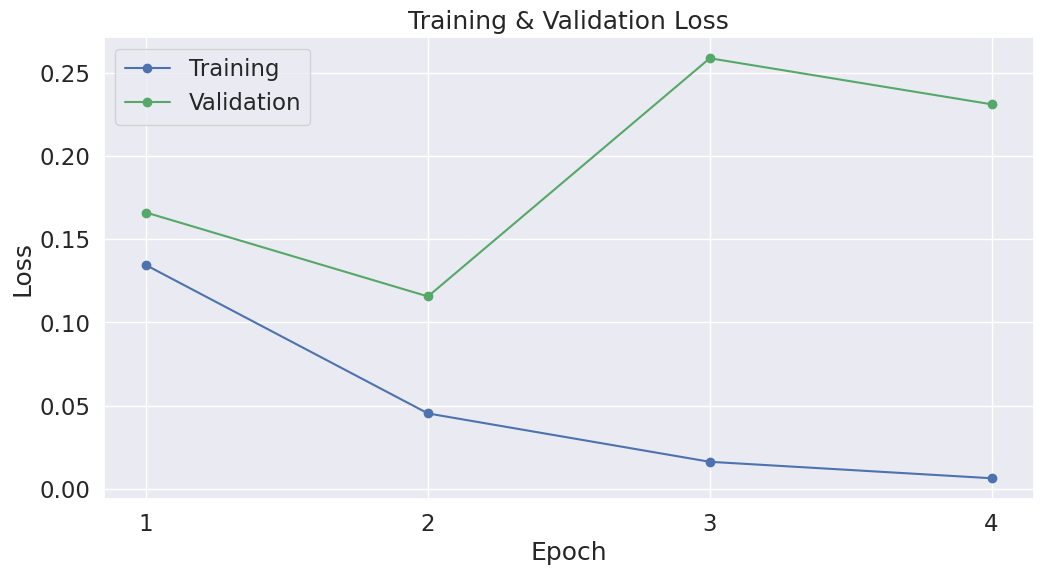

In [ ]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:


# Create sentence and label lists
sentences_test = test['text_']
labels_test = test['label']

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 8,086 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Concatenate predictions and true labels
predictions_np = np.concatenate(predictions, axis=0)
true_labels_np = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(predictions_np, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels_np, predicted_labels)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(true_labels_np, predicted_labels))


Accuracy: 0.9654959188721247
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4050
           1       0.99      0.94      0.96      4036

    accuracy                           0.97      8086
   macro avg       0.97      0.97      0.97      8086
weighted avg       0.97      0.97      0.97      8086



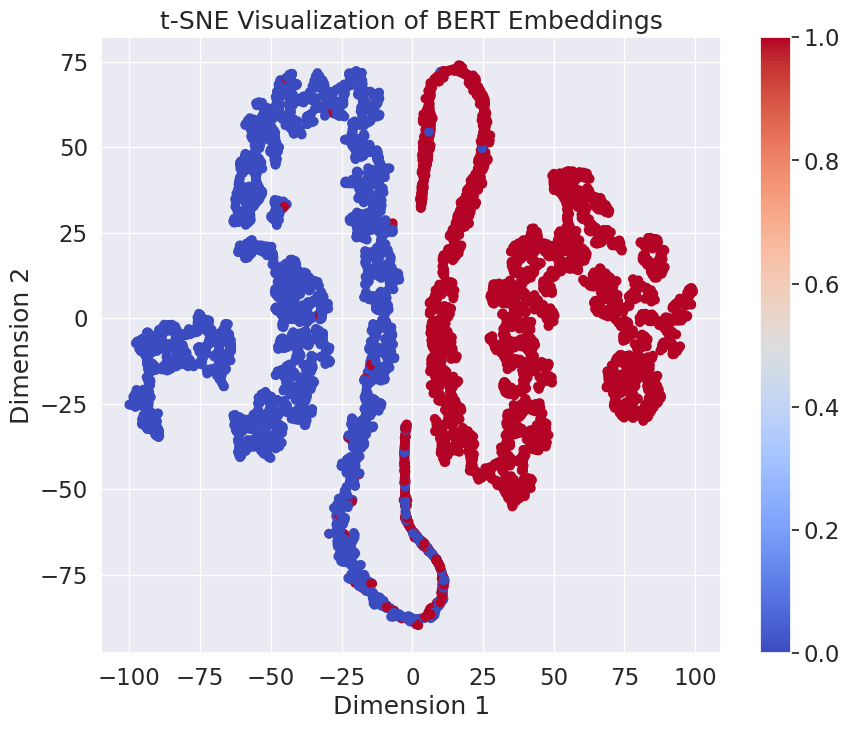

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract BERT embeddings for your test data (assuming model is already trained)
model.eval()
all_test_embeddings = []

for batch in prediction_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        embeddings = outputs[0]  # Extract the embeddings from the model output
        all_test_embeddings.extend(embeddings.cpu().numpy())

all_test_embeddings = np.array(all_test_embeddings)

# Perform dimensionality reduction (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_test_embeddings)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_test, cmap='coolwarm')
plt.colorbar()
plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
